# Simple PPO Agent (CityLearn)
Minimal end-to-end example: load schema, keep only electrical storage, wrap env for single-building central agent, train PPO briefly, evaluate, and plot rewards.

In [2]:
# Basic imports & versions
import sys, os, json, time, math, pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
import torch as th
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback
from citylearn.data import DataSet
from citylearn.citylearn import CityLearnEnv
print('Python:', sys.version.split()[0])
print('Torch :', th.__version__)

Couldn't import dot_parser, loading of dot files will not be possible.


2025-08-19 17:51:22.615563: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-19 17:51:22.629079: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755618682.644063 1173551 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755618682.648556 1173551 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755618682.659944 1173551 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Python: 3.11.7
Torch : 2.7.0+cu126


In [3]:
# Configuration
DATASET_NAME = 'citylearn_challenge_2023_phase_3_1'  # adjust if needed
ROOT_DIR = r'/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1'
REWARD_FN = {  # CostReward 
    'type': 'citylearn.reward_function.CostReward',
    'attributes': {}
}
ONLY_ELECTRICAL_STORAGE = True
TOTAL_TIMESTEPS = 2208 * 5
EVAL_EPISODES = 1

In [4]:
def keep_only_electrical_storage(schema: dict) -> dict:
    if 'actions' in schema:
        for a in list(schema['actions'].keys()):
            schema['actions'][a]['active'] = (a == 'electrical_storage')
    if 'buildings' in schema:
        for b in schema['buildings']:
            if 'actions' in b:
                for a in list(b['actions'].keys()):
                    b['actions'][a]['active'] = (a == 'electrical_storage')
    return schema

# --- Load schema ---
dataset = DataSet()
schema = dataset.get_schema(DATASET_NAME)
schema['root_directory'] = ROOT_DIR

# Action 1: actually deactivate all actions except electrical storage if flag is set
if ONLY_ELECTRICAL_STORAGE:
    schema = keep_only_electrical_storage(schema)

# Always set reward function (was previously inside the conditional)
schema['reward_function'] = REWARD_FN

# (Optional) custom pricing file override example
# for bname, bconf in schema['buildings'].items():
#     bconf['pricing'] = 'pricing_germany_2023_june_to_august.csv'

# Create underlying CityLearn environment (central agent)
cl_env = CityLearnEnv(schema, central_agent=True)
print('Underlying CL action_space building0:', cl_env.action_space[0])
print('Observation length (building0):', len(cl_env.observations[0]))

INFO:root:Go here /home/iai/cj9272/.cache/citylearn/v2.4.1/datasets/citylearn_challenge_2023_phase_3_1/schema.json 


/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-08-19_17-51-26'
Underlying CL action_space building0: Box(-1.0, 1.0, (6,), float32)
Observation length (building0): 85


### Wrapper Environment (Continuous [-1,1] Storage Control)

In [5]:
class CityLearnPPOWrapper(gym.Env):
    metadata = {'render_modes': []}
    def __init__(self, cl_env: CityLearnEnv):
        super().__init__()
        self.cl = cl_env
        self.cl.reset()
        obs0 = np.array(self.cl.observations[0], dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=obs0.shape, dtype=np.float32)
        # Determine original action dimension
        orig_dim = self.cl.action_space[0].shape[0]
        # If only electrical storage remains, orig_dim should be 1.
        # We still define a 1D agent action space; we'll expand to full if needed.
        self.agent_action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        self.action_space = self.agent_action_space
        # Try to find index of electrical storage if multiple dims survived (fallback 0)
        try:
            b0 = self.cl.buildings[0]
            # Attempt to parse device ordering from building actions structure
            # If not available, default to index 0
            self.storage_index = 0
        except Exception:
            self.storage_index = 0
        self.orig_dim = orig_dim

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.cl.reset(seed=seed)
        obs = np.array(self.cl.observations[0], dtype=np.float32)
        return obs, {}

    def step(self, action):
        # Expect a single scalar in [-1,1]
        a = np.clip(np.array(action, dtype=np.float32).reshape(-1), -1.0, 1.0)
        if a.size != 1:
            raise ValueError(f"Expected single action value, got shape {a.shape}")
        frac = float(a[0])
        if self.orig_dim == 1:
            actions = [[frac]]
        else:
            # Build full vector of zeros, insert frac at storage index; others neutral (0)
            full = np.zeros(self.orig_dim, dtype=np.float32)
            full[self.storage_index] = frac
            actions = [full.tolist()]
        obs_all, rewards, terminated, truncated, info = self.cl.step(actions)
        obs = np.array(obs_all[0], dtype=np.float32)
        reward = float(rewards[0])
        return obs, reward, bool(terminated), bool(truncated), info

    def render(self):
        pass

### PPO Callback for Logging

In [6]:
class PPOTrainLogger(BaseCallback):
    def __init__(self):
        super().__init__()
        self.rows = []  # per step
        self.ep_returns = []
        self._ep_ret = 0.0
    def _on_step(self):
        # Access locals: 'rewards', 'dones' if vectorized wrapper is used
        r = float(self.locals.get('rewards', [0])[0]) if isinstance(self.locals.get('rewards'), (list, tuple, np.ndarray)) else float(self.locals.get('rewards', 0))
        d = bool(self.locals.get('dones', [False])[0]) if isinstance(self.locals.get('dones'), (list, tuple, np.ndarray)) else bool(self.locals.get('dones', False))
        self._ep_ret += r
        self.rows.append({'timestep': int(self.num_timesteps), 'reward': r})
        if d:
            self.ep_returns.append(self._ep_ret)
            self._ep_ret = 0.0
            return True
    def _on_training_end(self):
        import pandas as pd
        self.step_df = pd.DataFrame(self.rows)
        self.ep_df = pd.DataFrame({'episode': range(1, len(self.ep_returns)+1), 'return': self.ep_returns})

### Build & Train PPO

In [7]:
env = Monitor(CityLearnPPOWrapper(cl_env))
logger_cb = PPOTrainLogger()
model = PPO(
    policy='MlpPolicy',
    env=env,
    learning_rate=3e-4,
    n_steps=2208,
    batch_size=256, # mini-batch size within each optimization epoch
    gamma=0.99, # discount factor future rewards
    gae_lambda=0.95, 
    clip_range=0.2,
    ent_coef=0.0,
    vf_coef=0.5,
    max_grad_norm=0.5,
    verbose=1,
    policy_kwargs=dict(net_arch=[256,256], activation_fn=th.nn.ReLU)
)
model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=logger_cb)

Using cuda device
Wrapping the env in a DummyVecEnv.


/hkfs/home/haicore/iai/cj9272/citylearn_env/lib64/python3.11/site-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 256, but because the `RolloutBuffer` is of size `n_steps * n_envs = 2208`, after every 8 untruncated mini-batches, there will be a truncated mini-batch of size 160
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=2208 and n_envs=1)
  warnings.warn(
/hkfs/home/haicore/iai/cj9272/citylearn_env/lib64/python3.11/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the

### Quick Evaluation

In [8]:
def evaluate(model, env, episodes=1):
    returns = []
    for i in range(episodes):
        obs, _ = env.reset()
        done = False
        ret = 0.0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            # action expected shape (1,) from wrapper
            obs, r, term, trunc, _ = env.step(action)
            ret += r
            done = term or trunc
        returns.append(ret)
        print(f"Return of episode {i + 1}: {ret}")
    return np.array(returns)

eval_returns = evaluate(model, env, episodes=EVAL_EPISODES)
print(f'Eval mean return over {EVAL_EPISODES} ep(s):', eval_returns.mean())

Return of episode 1: -563.5993097923139
Eval mean return over 1 ep(s): -563.5993097923139


### Plots

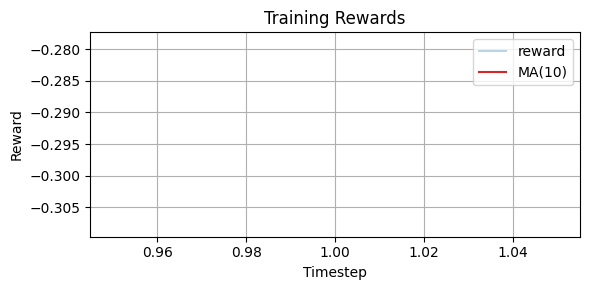

In [9]:
import pandas as pd
if hasattr(logger_cb, 'step_df'):
    step_df = logger_cb.step_df.copy()
    if not step_df.empty:
        # Reward moving average
        window = min(1000, max(10, len(step_df)//20))
        step_df['reward_ma'] = step_df['reward'].rolling(window, min_periods=1).mean()
        plt.figure(figsize=(6,3))
        plt.plot(step_df['timestep'], step_df['reward'], alpha=0.3, label='reward')
        plt.plot(step_df['timestep'], step_df['reward_ma'], color='C3', label=f'MA({window})')
        plt.xlabel('Timestep'); plt.ylabel('Reward'); plt.title('Training Rewards'); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()
if hasattr(logger_cb, 'ep_df') and len(logger_cb.ep_df):
    ep_df = logger_cb.ep_df
    plt.figure(figsize=(5,3))
    plt.plot(ep_df['episode'], ep_df['return'], marker='o')
    plt.xlabel('Episode'); plt.ylabel('Return'); plt.title('Episode Returns'); plt.grid(True); plt.tight_layout(); plt.show()

### Save Artifacts (Optional)

In [10]:
OUT_DIR = 'ppo_logs'
os.makedirs(OUT_DIR, exist_ok=True)
model_path = os.path.join(OUT_DIR, 'ppo_model.zip')
model.save(model_path)
print('Saved model to', model_path)
if hasattr(logger_cb, 'step_df'): logger_cb.step_df.to_csv(os.path.join(OUT_DIR,'train_steps.csv'), index=False)
if hasattr(logger_cb, 'ep_df'): logger_cb.ep_df.to_csv(os.path.join(OUT_DIR,'episode_returns.csv'), index=False)

Saved model to ppo_logs/ppo_model.zip


### Next Ideas
- Add VecNormalize for observation/reward normalization.
- Add EvalCallback for periodic evaluation.
- Tune hyperparameters (n_steps, batch_size, gamma).
- Switch reward function (ComfortReward etc.).
- Multi-building or multi-agent variants.